# EDA & Outlier Detection for Silver Layer Transformation
## PV Lakehouse - Bronze to Silver Data Quality Analysis

This notebook performs comprehensive exploratory data analysis (EDA) and outlier detection on Bronze layer data to inform Silver layer transformation logic. It includes:
- Physical bounds validation for each variable
- Temporal anomaly detection (timestamps, duplicates, gaps)
- Statistical outlier detection (IQR, 3-sigma rule)
- Time-of-day pattern validation (solar diurnal cycles)
- Data quality visualization and flagging


In [25]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
from typing import Dict, List, Tuple, Optional

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# For Spark
try:
    from pyspark.sql import SparkSession
    from pyspark.sql import functions as F
    from pyspark.sql import types as T
    print("✓ PySpark imported successfully")
except ImportError as e:
    print(f"⚠ PySpark import error: {e}")

# Initialize Spark session
try:
    spark = SparkSession.builder \
        .appName("eda-outlier-detection") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()
    print(f"✓ Spark session created: {spark.version}")
except Exception as e:
    print(f"⚠ Spark session error: {e}")

print("\n" + "="*80)
print("PV Lakehouse - Outlier Detection & Data Quality Analysis")
print("="*80)

✓ PySpark imported successfully
⚠ Spark session error: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

PV Lakehouse - Outlier Detection & Data Quality Analysis


your 131072x1 screen size is bogus. expect trouble
JAVA_HOME is not set


## 1. Load Bronze Layer Data

In [26]:
# Load Bronze layer tables from CSV files
print("Loading Bronze layer data from CSV files...")
import os

base_path = '/home/pvlakehouse/dlh-pv/src/pv_lakehouse/exported_data'

try:
    # Load Timeseries data
    print("\n📊 Loading Bronze Timeseries data...")
    timeseries_file = os.path.join(base_path, 'lh_bronze_raw_facility_timeseries.csv')
    timeseries_df = pd.read_csv(timeseries_file)
    print(f"✓ Loaded timeseries: {len(timeseries_df):,} rows")
    print(f"  Columns: {list(timeseries_df.columns)}")
    print(f"  Facilities: {timeseries_df['facility_code'].nunique()}")
    if 'interval_ts' in timeseries_df.columns:
        print(f"  Date range: {timeseries_df['interval_ts'].min()} to {timeseries_df['interval_ts'].max()}")
    
    # Load Weather data
    print("\n🌤️  Loading Bronze Weather data...")
    weather_file = os.path.join(base_path, 'lh_bronze_raw_facility_weather.csv')
    weather_df = pd.read_csv(weather_file)
    print(f"✓ Loaded weather: {len(weather_df):,} rows")
    print(f"  Columns: {list(weather_df.columns)}")
    print(f"  Facilities: {weather_df['facility_code'].nunique()}")
    
    # Load Air Quality data
    print("\n💨 Loading Bronze Air Quality data...")
    air_quality_file = os.path.join(base_path, 'lh_bronze_raw_facility_air_quality.csv')
    air_quality_df = pd.read_csv(air_quality_file)
    print(f"✓ Loaded air quality: {len(air_quality_df):,} rows")
    print(f"  Columns: {list(air_quality_df.columns)}")
    print(f"  Facilities: {air_quality_df['facility_code'].nunique()}")
    
    print("\n✅ All data loaded successfully!")
    
except FileNotFoundError as e:
    print(f"❌ File not found: {e}")
    timeseries_df = pd.DataFrame()
    weather_df = pd.DataFrame()
    air_quality_df = pd.DataFrame()
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()
    timeseries_df = pd.DataFrame()
    weather_df = pd.DataFrame()
    air_quality_df = pd.DataFrame()

print("\n" + "="*80)

Loading Bronze layer data from CSV files...

📊 Loading Bronze Timeseries data...
✓ Loaded timeseries: 81,355 rows
  Columns: ['network_code', 'network_id', 'network_region', 'facility_code', 'facility_name', 'unit_code', 'metric', 'interval', 'value_unit', 'interval_start', 'value', 'ingest_mode', 'ingest_timestamp', 'interval_ts', 'interval_date']
  Facilities: 5
  Date range: 2024-01-01T00:00:00.000Z to 2025-11-08T23:00:00.000Z

🌤️  Loading Bronze Weather data...
  Date range: 2024-01-01T00:00:00.000Z to 2025-11-08T23:00:00.000Z

🌤️  Loading Bronze Weather data...
✓ Loaded weather: 81,360 rows
  Columns: ['facility_code', 'facility_name', 'latitude', 'longitude', 'date', 'shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance', 'terrestrial_radiation', 'temperature_2m', 'dew_point_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'precipitation', 'is_day', 'sunshine_duration', 'total_column_integrated_water_vapour', 'bound

## 2. Exploratory Data Analysis - Overview Statistics

In [27]:
print("\n📊 TIMESERIES DATA - Descriptive Statistics")
print("="*80)
if not timeseries_df.empty:
    print(f"\nData types:\n{timeseries_df.dtypes}\n")
    numeric_cols = timeseries_df.select_dtypes(include=[np.number]).columns
    print(timeseries_df[numeric_cols].describe().round(4))
    print(f"\nMissing values:\n{timeseries_df.isnull().sum()}")
    print(f"\nRecords by facility:\n{timeseries_df['facility_code'].value_counts()}")
    print(f"\nMetrics in dataset: {timeseries_df['metric'].unique() if 'metric' in timeseries_df.columns else 'N/A'}")

print("\n\n📊 WEATHER DATA - Descriptive Statistics")
print("="*80)
if not weather_df.empty:
    numeric_cols = weather_df.select_dtypes(include=[np.number]).columns
    print(weather_df[numeric_cols].describe().round(4))
    print(f"\nMissing values (top 10):\n{weather_df.isnull().sum().sort_values(ascending=False).head(10)}")
    print(f"\nRecords by facility:\n{weather_df['facility_code'].value_counts()}")

print("\n\n📊 AIR QUALITY DATA - Descriptive Statistics")
print("="*80)
if not air_quality_df.empty:
    numeric_cols = air_quality_df.select_dtypes(include=[np.number]).columns
    print(air_quality_df[numeric_cols].describe().round(4))
    print(f"\nMissing values (top 10):\n{air_quality_df.isnull().sum().sort_values(ascending=False).head(10)}")
    print(f"\nRecords by facility:\n{air_quality_df['facility_code'].value_counts()}")


📊 TIMESERIES DATA - Descriptive Statistics

Data types:
network_code         object
network_id           object
network_region       object
facility_code        object
facility_name        object
unit_code            object
metric               object
interval             object
value_unit           object
interval_start       object
value               float64
ingest_mode          object
ingest_timestamp     object
interval_ts          object
interval_date        object
dtype: object

            value
count  81355.0000
mean      21.7328
std       34.2643
min        0.0000
25%        0.0000
50%        0.0867
75%       35.5001
max      148.3427

Missing values:
network_code        0
network_id          0
network_region      0
facility_code       0
facility_name       0
unit_code           0
metric              0
interval            0
value_unit          0
interval_start      0
value               0
ingest_mode         0
ingest_timestamp    0
interval_ts         0
interval_date       0

## 3. Physical Bounds Validation

Define physically valid ranges for each variable based on domain knowledge:

In [28]:
# Define physical bounds for each variable
PHYSICAL_BOUNDS = {
    # Energy/Power
    'value': (0.0, None),  # Energy must be non-negative
    'energy_mwh': (0.0, None),
    'power_mw': (0.0, None),
    
    # Weather - Radiation
    'shortwave_radiation': (0.0, 1500.0),  # W/m² - solar radiation
    'direct_radiation': (0.0, 1500.0),
    'diffuse_radiation': (0.0, 1500.0),
    'direct_normal_irradiance': (0.0, 1500.0),
    'terrestrial_radiation': (0.0, 100.0),
    
    # Weather - Temperature
    'temperature_2m': (-50.0, 60.0),  # °C at 2m height
    'dew_point_2m': (-50.0, 60.0),
    'wet_bulb_temperature_2m': (-50.0, 60.0),
    
    # Weather - Humidity & Pressure
    'cloud_cover': (0.0, 100.0),  # %
    'cloud_cover_low': (0.0, 100.0),
    'cloud_cover_mid': (0.0, 100.0),
    'cloud_cover_high': (0.0, 100.0),
    'precipitation': (0.0, 1000.0),  # mm
    'total_column_integrated_water_vapour': (0.0, 100.0),
    'sunshine_duration': (0.0, 3600.0),  # seconds
    'pressure_msl': (800.0, 1100.0),  # hPa
    
    # Weather - Wind
    'wind_speed_10m': (0.0, 60.0),  # m/s
    'wind_direction_10m': (0.0, 360.0),  # degrees
    'wind_gusts_10m': (0.0, 120.0),  # m/s
    'boundary_layer_height': (0.0, 10000.0),  # meters
    
    # Air Quality
    'pm2_5': (0.0, 500.0),  # μg/m³
    'pm10': (0.0, 500.0),
    'dust': (0.0, 500.0),
    'nitrogen_dioxide': (0.0, 500.0),  # ppb equivalent
    'ozone': (0.0, 500.0),
    'sulphur_dioxide': (0.0, 500.0),
    'carbon_monoxide': (0.0, 10000.0),  # ppb
    'uv_index': (0.0, 15.0),
    'uv_index_clear_sky': (0.0, 15.0),
}

def check_physical_bounds(df: pd.DataFrame, bounds: Dict[str, Tuple]) -> pd.DataFrame:
    """Check if values are within physical bounds."""
    violations = pd.DataFrame({
        'total_rows': [len(df)],
        'valid_rows': [len(df)]
    })
    
    for col, (min_val, max_val) in bounds.items():
        if col not in df.columns:
            continue
        
        # Count violations
        if min_val is not None and max_val is not None:
            violation = ((df[col] < min_val) | (df[col] > max_val)) & df[col].notna()
        elif min_val is not None:
            violation = (df[col] < min_val) & df[col].notna()
        else:
            violation = (df[col] > max_val) & df[col].notna()
        
        violations[f'{col}_violations'] = violation.sum()
        violations[f'{col}_violation_pct'] = (violation.sum() / len(df) * 100).round(2)
    
    return violations

print("\n🔬 TIMESERIES - Physical Bounds Violations")
print("="*80)
if not timeseries_df.empty:
    ts_violations = check_physical_bounds(timeseries_df, PHYSICAL_BOUNDS)
    print(ts_violations.T)
    timeseries_df['is_within_bounds'] = True
    for col, (min_val, max_val) in PHYSICAL_BOUNDS.items():
        if col in timeseries_df.columns:
            if min_val is not None and max_val is not None:
                timeseries_df['is_within_bounds'] &= ((timeseries_df[col] >= min_val) & (timeseries_df[col] <= max_val)) | timeseries_df[col].isna()

print("\n\n🔬 WEATHER - Physical Bounds Violations")
print("="*80)
if not weather_df.empty:
    weather_violations = check_physical_bounds(weather_df, PHYSICAL_BOUNDS)
    print(weather_violations.T)
    weather_df['is_within_bounds'] = True
    for col, (min_val, max_val) in PHYSICAL_BOUNDS.items():
        if col in weather_df.columns:
            if min_val is not None and max_val is not None:
                weather_df['is_within_bounds'] &= ((weather_df[col] >= min_val) & (weather_df[col] <= max_val)) | weather_df[col].isna()

print("\n\n🔬 AIR QUALITY - Physical Bounds Violations")
print("="*80)
if not air_quality_df.empty:
    air_violations = check_physical_bounds(air_quality_df, PHYSICAL_BOUNDS)
    print(air_violations.T)
    air_quality_df['is_within_bounds'] = True
    for col, (min_val, max_val) in PHYSICAL_BOUNDS.items():
        if col in air_quality_df.columns:
            if min_val is not None and max_val is not None:
                air_quality_df['is_within_bounds'] &= ((air_quality_df[col] >= min_val) & (air_quality_df[col] <= max_val)) | air_quality_df[col].isna()


🔬 TIMESERIES - Physical Bounds Violations
                           0
total_rows           81355.0
valid_rows           81355.0
value_violations         0.0
value_violation_pct      0.0


🔬 WEATHER - Physical Bounds Violations
                                                           0
total_rows                                          81360.00
valid_rows                                          81360.00
shortwave_radiation_violations                          0.00
shortwave_radiation_violation_pct                       0.00
direct_radiation_violations                             0.00
direct_radiation_violation_pct                          0.00
diffuse_radiation_violations                            0.00
diffuse_radiation_violation_pct                         0.00
direct_normal_irradiance_violations                     0.00
direct_normal_irradiance_violation_pct                  0.00
terrestrial_radiation_violations                    38228.00
terrestrial_radiation_violation_pct    

## 4. Temporal Anomaly Detection

In [29]:
def check_temporal_anomalies(df: pd.DataFrame, timestamp_col: str) -> Dict:
    """Detect timestamp issues: nulls, duplicates, gaps, future dates."""
    df_temp = df.copy()
    
    # Convert timestamp to datetime if string
    if df_temp[timestamp_col].dtype == 'object':
        df_temp[timestamp_col] = pd.to_datetime(df_temp[timestamp_col], errors='coerce')
    
    # Get current time with matching timezone
    ts_col_data = df_temp[timestamp_col]
    if hasattr(ts_col_data.dt, 'tz') and ts_col_data.dt.tz is not None:
        now = pd.Timestamp.now(tz='UTC')
    else:
        now = pd.Timestamp.now()
    
    anomalies = {
        'total_rows': len(df_temp),
        'null_timestamps': df_temp[timestamp_col].isna().sum(),
        'future_timestamps': ((df_temp[timestamp_col] > now)).sum() if timestamp_col in df_temp.columns else 0,
        'duplicate_timestamps': 0,
        'time_gaps_detected': False
    }
    
    # Check duplicates by facility and timestamp
    if 'facility_code' in df_temp.columns:
        key_cols = [c for c in ['facility_code', timestamp_col] if c in df_temp.columns]
        dup_count = df_temp.duplicated(subset=key_cols, keep=False).sum()
        anomalies['duplicate_timestamps'] = dup_count
    
    return anomalies

print("\n⏰ TIMESERIES - Temporal Anomalies")
print("="*80)
if not timeseries_df.empty:
    ts_col = 'interval_ts' if 'interval_ts' in timeseries_df.columns else 'date'
    if ts_col in timeseries_df.columns:
        ts_temporal = check_temporal_anomalies(timeseries_df, ts_col)
        for k, v in ts_temporal.items():
            print(f"  {k}: {v}")
        # Convert and create valid_timestamp
        if timeseries_df[ts_col].dtype == 'object':
            timeseries_df[ts_col] = pd.to_datetime(timeseries_df[ts_col], errors='coerce')
        if hasattr(timeseries_df[ts_col].dt, 'tz') and timeseries_df[ts_col].dt.tz is not None:
            now_utc = pd.Timestamp.now(tz='UTC')
        else:
            now_utc = pd.Timestamp.now()
        timeseries_df['valid_timestamp'] = timeseries_df[ts_col].notna() & (timeseries_df[ts_col] <= now_utc)

print("\n⏰ WEATHER - Temporal Anomalies")
print("="*80)
if not weather_df.empty:
    ts_col = 'date' if 'date' in weather_df.columns else 'weather_timestamp'
    if ts_col in weather_df.columns:
        weather_temporal = check_temporal_anomalies(weather_df, ts_col)
        for k, v in weather_temporal.items():
            print(f"  {k}: {v}")
        if weather_df[ts_col].dtype == 'object':
            weather_df[ts_col] = pd.to_datetime(weather_df[ts_col], errors='coerce')
        if hasattr(weather_df[ts_col].dt, 'tz') and weather_df[ts_col].dt.tz is not None:
            now_utc = pd.Timestamp.now(tz='UTC')
        else:
            now_utc = pd.Timestamp.now()
        weather_df['valid_timestamp'] = weather_df[ts_col].notna() & (weather_df[ts_col] <= now_utc)

print("\n⏰ AIR QUALITY - Temporal Anomalies")
print("="*80)
if not air_quality_df.empty:
    ts_col = 'date' if 'date' in air_quality_df.columns else 'air_timestamp'
    if ts_col in air_quality_df.columns:
        air_temporal = check_temporal_anomalies(air_quality_df, ts_col)
        for k, v in air_temporal.items():
            print(f"  {k}: {v}")
        if air_quality_df[ts_col].dtype == 'object':
            air_quality_df[ts_col] = pd.to_datetime(air_quality_df[ts_col], errors='coerce')
        if hasattr(air_quality_df[ts_col].dt, 'tz') and air_quality_df[ts_col].dt.tz is not None:
            now_utc = pd.Timestamp.now(tz='UTC')
        else:
            now_utc = pd.Timestamp.now()
        air_quality_df['valid_timestamp'] = air_quality_df[ts_col].notna() & (air_quality_df[ts_col] <= now_utc)


⏰ TIMESERIES - Temporal Anomalies
  total_rows: 81355
  null_timestamps: 0
  future_timestamps: 0
  duplicate_timestamps: 0
  time_gaps_detected: False

⏰ WEATHER - Temporal Anomalies
  total_rows: 81360
  null_timestamps: 0
  future_timestamps: 0
  duplicate_timestamps: 0
  time_gaps_detected: False

⏰ AIR QUALITY - Temporal Anomalies
  total_rows: 81360
  null_timestamps: 0
  future_timestamps: 0
  duplicate_timestamps: 0
  time_gaps_detected: False

⏰ AIR QUALITY - Temporal Anomalies
  total_rows: 81360
  null_timestamps: 0
  future_timestamps: 0
  duplicate_timestamps: 0
  time_gaps_detected: False


## 5. Distribution Analysis and Statistical Outliers

In [30]:
def detect_statistical_outliers(data: pd.Series, method='tukey', name='') -> Dict:
    """Detect outliers using multiple methods: IQR (Tukey), Z-score (3-sigma)."""
    results = {
        'name': name,
        'total': len(data),
        'non_null': data.notna().sum(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max()
    }
    
    # Tukey's IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    tukey_outliers = ((data < lower_fence) | (data > upper_fence)) & data.notna()
    results['tukey_outliers'] = tukey_outliers.sum()
    results['tukey_outlier_pct'] = (tukey_outliers.sum() / data.notna().sum() * 100).round(2) if data.notna().sum() > 0 else 0
    results['tukey_bounds'] = (lower_fence, upper_fence)
    
    # Z-score method (3-sigma)
    z_scores = np.abs(stats.zscore(data.dropna(), nan_policy='omit'))
    zscore_outliers_count = (z_scores > 3).sum()
    results['zscore_outliers'] = zscore_outliers_count
    results['zscore_outlier_pct'] = (zscore_outliers_count / data.notna().sum() * 100).round(2) if data.notna().sum() > 0 else 0
    
    return results

# Analyze energy data
print("\n📈 ENERGY DATA - Distribution & Statistical Outliers")
print("="*80)
if not timeseries_df.empty and 'value' in timeseries_df.columns:
    energy_stats = detect_statistical_outliers(timeseries_df['value'], name='Energy (MWh)')
    for k, v in energy_stats.items():
        if k not in ['tukey_bounds']:
            print(f"  {k}: {v}")
    print(f"  Tukey bounds (IQR): [{energy_stats['tukey_bounds'][0]:.2f}, {energy_stats['tukey_bounds'][1]:.2f}]")

# Analyze weather data - key variables
print("\n\n📈 WEATHER DATA - Distribution & Statistical Outliers")
print("="*80)
if not weather_df.empty:
    weather_key_vars = ['shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'cloud_cover']
    for var in weather_key_vars:
        if var in weather_df.columns:
            stats_result = detect_statistical_outliers(weather_df[var], name=var)
            print(f"\n  {var}:")
            print(f"    Mean: {stats_result['mean']:.2f}, Std: {stats_result['std']:.2f}")
            print(f"    Tukey outliers: {stats_result['tukey_outliers']} ({stats_result['tukey_outlier_pct']}%)")
            print(f"    Z-score outliers (>3σ): {stats_result['zscore_outliers']} ({stats_result['zscore_outlier_pct']}%)")

# Analyze air quality data
print("\n\n📈 AIR QUALITY DATA - Distribution & Statistical Outliers")
print("="*80)
if not air_quality_df.empty:
    air_key_vars = ['pm2_5', 'pm10', 'uv_index']
    for var in air_key_vars:
        if var in air_quality_df.columns:
            stats_result = detect_statistical_outliers(air_quality_df[var], name=var)
            print(f"\n  {var}:")
            print(f"    Mean: {stats_result['mean']:.2f}, Std: {stats_result['std']:.2f}")
            print(f"    Tukey outliers: {stats_result['tukey_outliers']} ({stats_result['tukey_outlier_pct']}%)")
            print(f"    Z-score outliers (>3σ): {stats_result['zscore_outliers']} ({stats_result['zscore_outlier_pct']}%)")


📈 ENERGY DATA - Distribution & Statistical Outliers
  name: Energy (MWh)
  total: 81355
  non_null: 81355
  mean: 21.7328240993178
  median: 0.0867
  std: 34.264319904714746
  min: 0.0
  max: 148.3427
  tukey_outliers: 6244
  tukey_outlier_pct: 7.68
  zscore_outliers: 1237
  zscore_outlier_pct: 1.52
  Tukey bounds (IQR): [-53.25, 88.75]


📈 WEATHER DATA - Distribution & Statistical Outliers

  shortwave_radiation:
    Mean: 214.21, Std: 297.54
    Tukey outliers: 786 (0.97%)
    Z-score outliers (>3σ): 7 (0.01%)

  temperature_2m:
    Mean: 19.05, Std: 7.98
    Tukey outliers: 24 (0.03%)
    Z-score outliers (>3σ): 24 (0.03%)

  wind_speed_10m:
    Mean: 11.67, Std: 6.13
    Tukey outliers: 1398 (1.72%)
    Z-score outliers (>3σ): 676 (0.83%)

  cloud_cover:
    Mean: 39.94, Std: 42.44
    Tukey outliers: 0 (0.0%)
    Z-score outliers (>3σ): 0 (0.0%)


📈 AIR QUALITY DATA - Distribution & Statistical Outliers

  pm2_5:
    Mean: 3.01, Std: 2.36
    Tukey outliers: 3001 (3.69%)
    Z-sc

## 6. Time-of-Day Pattern Validation (Diurnal Patterns for Solar)

In [31]:
# Define diurnal pattern rules for solar PV
DIURNAL_RULES = {
    'night_hours': (22, 6),  # 22:00-06:00
    'peak_hours': (10, 15),  # 10:00-15:00
    'max_night_energy_mwh': 0.1,  # Very small amount allowed (measurement noise)
    'min_peak_day_energy_mwh': 1.0,  # Should have significant output
}

def validate_diurnal_pattern(df: pd.DataFrame, timestamp_col: str, value_col: str = 'value') -> Dict:
    """Check if solar energy follows expected diurnal pattern."""
    if timestamp_col not in df.columns or value_col not in df.columns:
        return {'error': f'Missing columns: {timestamp_col}, {value_col}'}
    
    df_copy = df.copy()
    df_copy['hour'] = pd.to_datetime(df_copy[timestamp_col]).dt.hour
    
    # Night energy (should be ~0)
    night_mask = df_copy['hour'].isin(range(DIURNAL_RULES['night_hours'][0], 24)) | \
                 df_copy['hour'].isin(range(0, DIURNAL_RULES['night_hours'][1]))
    night_high = (df_copy.loc[night_mask, value_col] > DIURNAL_RULES['max_night_energy_mwh']).sum()
    
    # Peak hours energy (should be significant)
    peak_mask = df_copy['hour'].isin(range(DIURNAL_RULES['peak_hours'][0], DIURNAL_RULES['peak_hours'][1]))
    peak_low = (df_copy.loc[peak_mask, value_col] < DIURNAL_RULES['min_peak_day_energy_mwh']).sum()
    
    return {
        'total_records': len(df_copy),
        'night_high_anomalies': night_high,
        'night_high_pct': (night_high / night_mask.sum() * 100).round(2) if night_mask.sum() > 0 else 0,
        'peak_low_anomalies': peak_low,
        'peak_low_pct': (peak_low / peak_mask.sum() * 100).round(2) if peak_mask.sum() > 0 else 0,
    }

print("\n☀️ SOLAR DIURNAL PATTERN VALIDATION")
print("="*80)
print(f"Night hours (should be ~0): {DIURNAL_RULES['night_hours'][0]}:00-{DIURNAL_RULES['night_hours'][1]}:00")
print(f"Peak hours (should be high): {DIURNAL_RULES['peak_hours'][0]}:00-{DIURNAL_RULES['peak_hours'][1]}:00")
print(f"Max allowed night energy: {DIURNAL_RULES['max_night_energy_mwh']} MWh")
print()

if not timeseries_df.empty and 'value' in timeseries_df.columns:
    ts_col = 'interval_ts' if 'interval_ts' in timeseries_df.columns else 'date'
    if ts_col in timeseries_df.columns:
        diurnal_result = validate_diurnal_pattern(timeseries_df, ts_col, 'value')
        for k, v in diurnal_result.items():
            print(f"  {k}: {v}")
        
        # Flag suspicious records
        df_temp = timeseries_df.copy()
        df_temp['hour'] = pd.to_datetime(df_temp[ts_col]).dt.hour
        night_mask_temp = df_temp['hour'].isin(range(DIURNAL_RULES['night_hours'][0], 24)) | \
                         df_temp['hour'].isin(range(0, DIURNAL_RULES['night_hours'][1]))
        df_temp['night_energy_anomaly'] = night_mask_temp & (df_temp['value'] > DIURNAL_RULES['max_night_energy_mwh'])
        
        if df_temp['night_energy_anomaly'].sum() > 0:
            print(f"\n  ⚠️ Example anomalies (high night energy):")
            anomaly_examples = df_temp[df_temp['night_energy_anomaly']][['facility_code', ts_col, 'hour', 'value']].head(10)
            print(anomaly_examples.to_string(index=False))


☀️ SOLAR DIURNAL PATTERN VALIDATION
Night hours (should be ~0): 22:00-6:00
Peak hours (should be high): 10:00-15:00
Max allowed night energy: 0.1 MWh

  total_records: 81355
  night_high_anomalies: 383
  night_high_pct: 1.41
  peak_low_anomalies: 1662
  peak_low_pct: 9.81

  ⚠️ Example anomalies (high night energy):
facility_code               interval_ts  hour  value
      COLEASF 2024-01-01 05:00:00+00:00     5 3.8333
      COLEASF 2024-01-02 05:00:00+00:00     5 0.1958
      COLEASF 2024-01-03 05:00:00+00:00     5 2.3875
      COLEASF 2024-01-04 05:00:00+00:00     5 0.9998
      COLEASF 2024-01-05 05:00:00+00:00     5 1.3042
      COLEASF 2024-01-06 05:00:00+00:00     5 1.8043
      COLEASF 2024-01-09 05:00:00+00:00     5 1.6333
      COLEASF 2024-01-10 05:00:00+00:00     5 1.5831
      COLEASF 2024-01-11 05:00:00+00:00     5 1.4043
      COLEASF 2024-01-12 05:00:00+00:00     5 0.4668


## 7. Data Quality Visualization

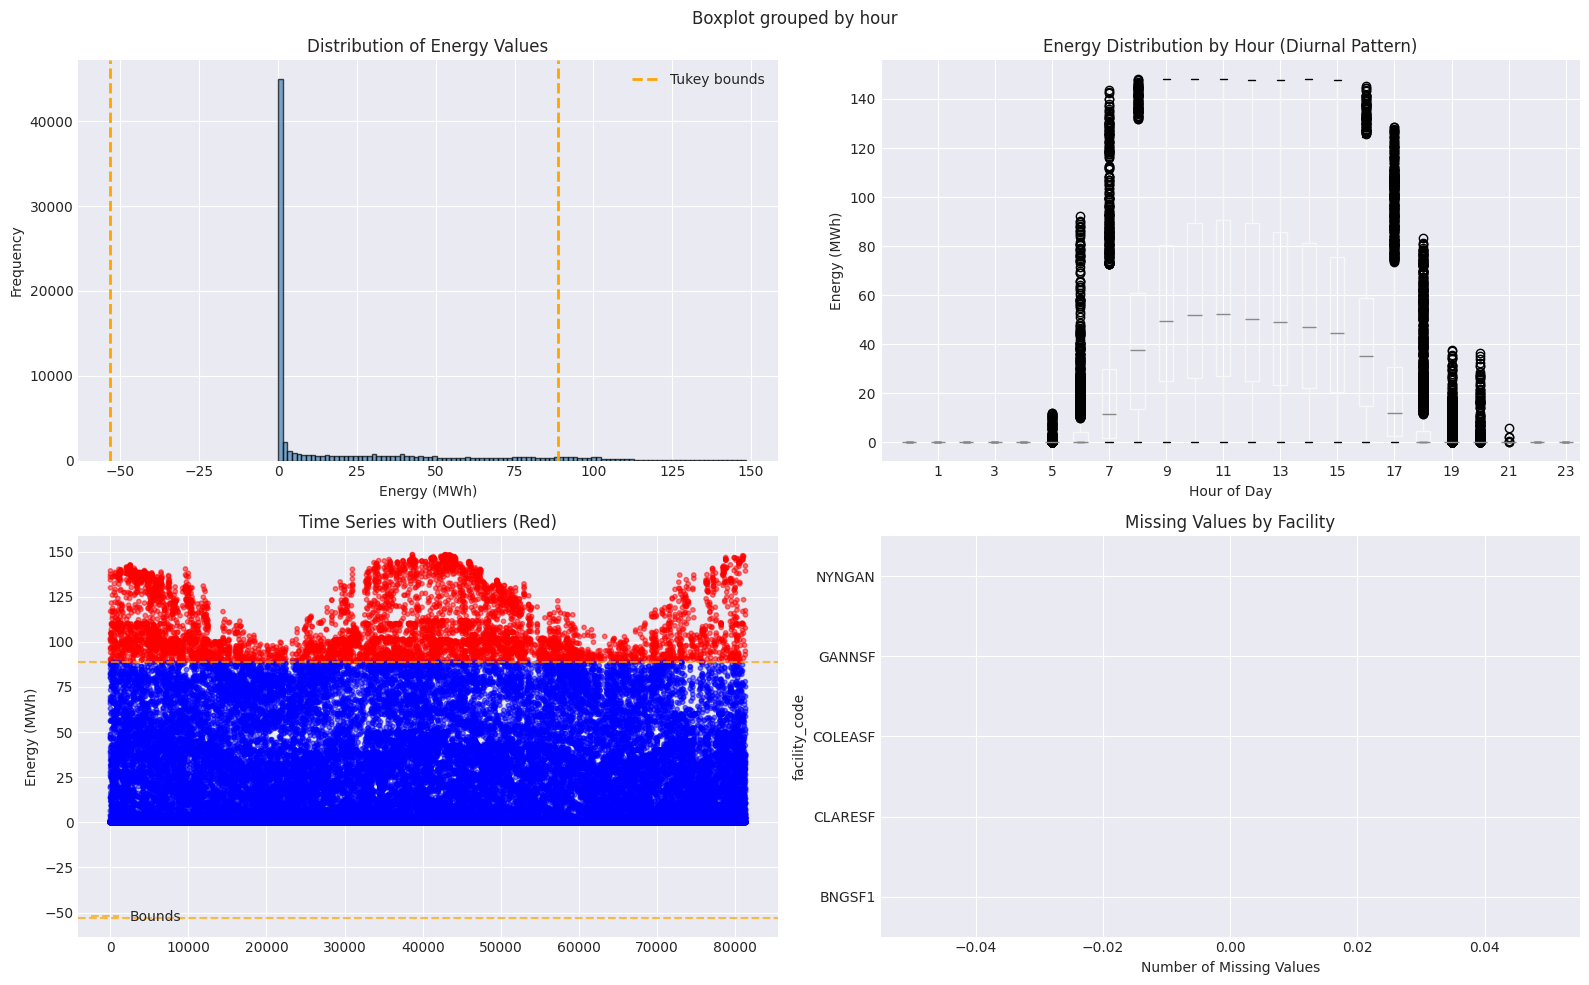


✅ Visualization complete


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Energy Data - Quality Visualization', fontsize=16, fontweight='bold')

if not timeseries_df.empty and 'value' in timeseries_df.columns:
    ts_col = 'interval_ts' if 'interval_ts' in timeseries_df.columns else 'date'
    
    # 1. Distribution with outlier bounds
    ax = axes[0, 0]
    data_clean = timeseries_df['value'].dropna()
    ax.hist(data_clean, bins=100, alpha=0.7, edgecolor='black', color='steelblue')
    Q1, Q3 = data_clean.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    ax.axvline(lower_fence, color='orange', linestyle='--', linewidth=2, label=f'Tukey bounds')
    ax.axvline(upper_fence, color='orange', linestyle='--', linewidth=2)
    ax.set_xlabel('Energy (MWh)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Energy Values')
    ax.legend()
    
    # 2. Box plot by hour of day
    ax = axes[0, 1]
    df_temp = timeseries_df.copy()
    df_temp['hour'] = pd.to_datetime(df_temp[ts_col]).dt.hour
    df_temp.boxplot(column='value', by='hour', ax=ax)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Energy (MWh)')
    ax.set_title('Energy Distribution by Hour (Diurnal Pattern)')
    plt.sca(ax)
    plt.xticks(range(0, 25, 2))
    
    # 3. Time series with outliers highlighted
    ax = axes[1, 0]
    df_temp_sorted = df_temp.sort_values(ts_col)
    is_outlier = (df_temp_sorted['value'] < lower_fence) | (df_temp_sorted['value'] > upper_fence)
    ax.scatter(range(len(df_temp_sorted)), df_temp_sorted['value'], 
              c=['red' if x else 'blue' for x in is_outlier], alpha=0.5, s=10)
    ax.axhline(lower_fence, color='orange', linestyle='--', alpha=0.7, label='Bounds')
    ax.axhline(upper_fence, color='orange', linestyle='--', alpha=0.7)
    ax.set_ylabel('Energy (MWh)')
    ax.set_title('Time Series with Outliers (Red)')
    ax.legend()
    
    # 4. Missing value heatmap by facility
    ax = axes[1, 1]
    missing_by_facility = timeseries_df.groupby('facility_code')['value'].apply(lambda x: x.isna().sum())
    missing_by_facility.plot(kind='barh', ax=ax, color='coral')
    ax.set_xlabel('Number of Missing Values')
    ax.set_title('Missing Values by Facility')

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete")

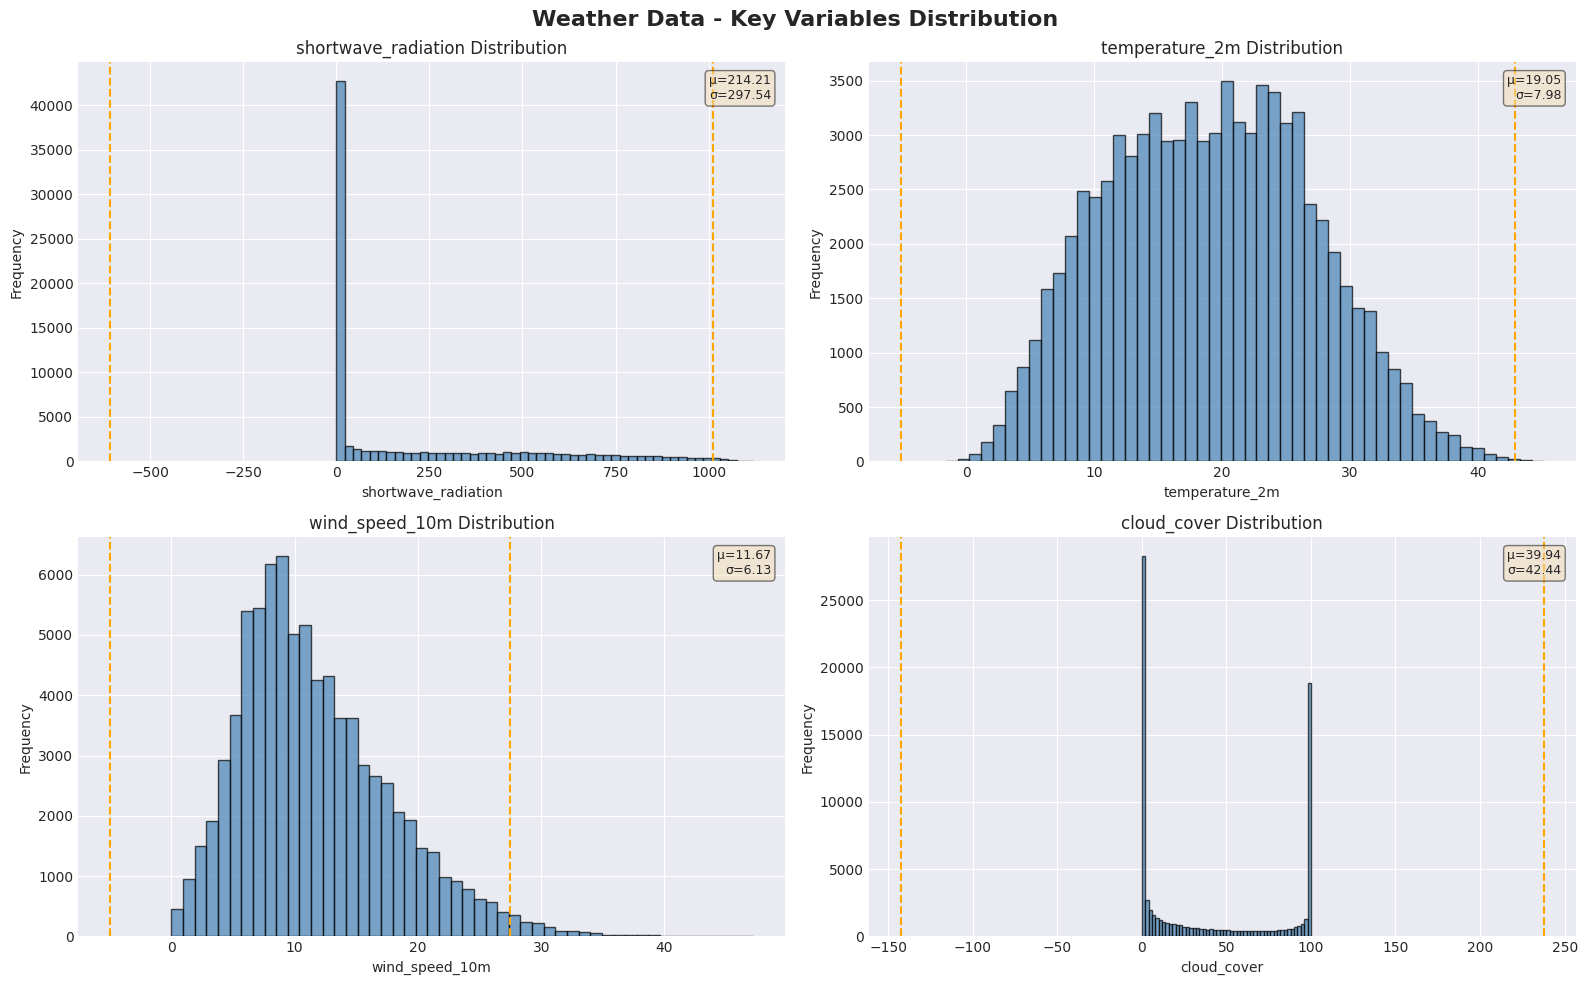

✅ Weather visualization complete


In [33]:
# Weather data visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Weather Data - Key Variables Distribution', fontsize=16, fontweight='bold')

if not weather_df.empty:
    vars_to_plot = ['shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'cloud_cover']
    for idx, var in enumerate(vars_to_plot):
        ax = axes[idx // 2, idx % 2]
        if var in weather_df.columns:
            data = weather_df[var].dropna()
            ax.hist(data, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
            Q1, Q3 = data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower_fence = Q1 - 1.5 * IQR
            upper_fence = Q3 + 1.5 * IQR
            ax.axvline(lower_fence, color='orange', linestyle='--', linewidth=1.5)
            ax.axvline(upper_fence, color='orange', linestyle='--', linewidth=1.5)
            ax.set_xlabel(var)
            ax.set_ylabel('Frequency')
            ax.set_title(f'{var} Distribution')
            ax.text(0.98, 0.97, f'μ={data.mean():.2f}\nσ={data.std():.2f}', 
                   transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Weather visualization complete")

## 8. Outlier Flagging and Exclusion Logic

In [34]:
def create_quality_flag(df: pd.DataFrame, timestamp_col: str = 'interval_ts', 
                        value_col: str = 'value', facility_col: str = 'facility_code') -> pd.DataFrame:
    """Create comprehensive quality flags combining all validation checks."""
    df = df.copy()
    
    # Initialize flags
    df['quality_flag'] = 'GOOD'
    df['quality_issues'] = ''
    
    # 1. Physical bounds check
    if value_col in df.columns:
        bounds = PHYSICAL_BOUNDS.get(value_col)
        if bounds:
            min_val, max_val = bounds
            if min_val is not None:
                oob_low = df[value_col] < min_val
                df.loc[oob_low, 'quality_flag'] = 'REJECT'
                df.loc[oob_low, 'quality_issues'] += 'OUT_OF_BOUNDS_LOW|'
            if max_val is not None:
                oob_high = df[value_col] > max_val
                df.loc[oob_high, 'quality_flag'] = 'REJECT'
                df.loc[oob_high, 'quality_issues'] += 'OUT_OF_BOUNDS_HIGH|'
    
    # 2. Temporal checks
    if timestamp_col in df.columns:
        null_ts = df[timestamp_col].isna()
        df.loc[null_ts, 'quality_flag'] = 'REJECT'
        df.loc[null_ts, 'quality_issues'] += 'NULL_TIMESTAMP|'
        
        # Handle timezone-aware timestamps
        ts_data = df[timestamp_col]
        if hasattr(ts_data.dt, 'tz') and ts_data.dt.tz is not None:
            now = pd.Timestamp.now(tz='UTC')
        else:
            now = pd.Timestamp.now()
        
        future_ts = ts_data > now
        df.loc[future_ts, 'quality_flag'] = 'REJECT'
        df.loc[future_ts, 'quality_issues'] += 'FUTURE_TIMESTAMP|'
    
    # 3. Statistical outliers (IQR method) - CAUTION level
    if value_col in df.columns:
        data = df[value_col].dropna()
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR
        is_statistical_outlier = ((df[value_col] < lower_fence) | (df[value_col] > upper_fence)) & df[value_col].notna()
        df.loc[is_statistical_outlier & (df['quality_flag'] == 'GOOD'), 'quality_flag'] = 'CAUTION'
        df.loc[is_statistical_outlier, 'quality_issues'] += 'STATISTICAL_OUTLIER|'
    
    # 4. Diurnal pattern check for solar
    if timestamp_col in df.columns and value_col in df.columns:
        df_temp = df.copy()
        df_temp['hour'] = pd.to_datetime(df_temp[timestamp_col]).dt.hour
        night_mask = df_temp['hour'].isin(range(22, 24)) | df_temp['hour'].isin(range(0, 6))
        night_high = night_mask & (df_temp[value_col] > DIURNAL_RULES['max_night_energy_mwh'])
        df.loc[night_high & (df['quality_flag'] == 'GOOD'), 'quality_flag'] = 'CAUTION'
        df.loc[night_high, 'quality_issues'] += 'NIGHT_ENERGY_ANOMALY|'
    
    # Clean up quality_issues
    df['quality_issues'] = df['quality_issues'].str.rstrip('|')
    
    return df

print("\n🚩 ENERGY DATA - Quality Flagging")
print("="*80)
if not timeseries_df.empty:
    ts_col = 'interval_ts' if 'interval_ts' in timeseries_df.columns else 'date'
    timeseries_flagged = create_quality_flag(timeseries_df, timestamp_col=ts_col, value_col='value')
    
    quality_counts = timeseries_flagged['quality_flag'].value_counts()
    print(f"\nQuality flag distribution:")
    for flag, count in quality_counts.items():
        pct = (count / len(timeseries_flagged) * 100)
        print(f"  {flag}: {count:,} ({pct:.2f}%)")
    
    print(f"\nTop quality issues:")
    all_issues = timeseries_flagged[timeseries_flagged['quality_issues'] != '']['quality_issues'].str.split('|').explode().value_counts()
    for issue, count in all_issues.head(10).items():
        print(f"  {issue}: {count:,}")
    
    print(f"\nExamples of REJECT records:")
    reject_records = timeseries_flagged[timeseries_flagged['quality_flag'] == 'REJECT'].head(10)
    print(reject_records[['facility_code', ts_col, 'value', 'quality_issues']].to_string(index=False))
    
    print(f"\nExamples of CAUTION records:")
    caution_records = timeseries_flagged[timeseries_flagged['quality_flag'] == 'CAUTION'].head(10)
    print(caution_records[['facility_code', ts_col, 'value', 'quality_issues']].to_string(index=False))


🚩 ENERGY DATA - Quality Flagging

Quality flag distribution:
  GOOD: 74,728 (91.85%)
  CAUTION: 6,627 (8.15%)

Top quality issues:
  STATISTICAL_OUTLIER: 6,244
  NIGHT_ENERGY_ANOMALY: 383

Examples of REJECT records:
Empty DataFrame
Columns: [facility_code, interval_ts, value, quality_issues]
Index: []

Examples of CAUTION records:
facility_code               interval_ts    value       quality_issues
      COLEASF 2024-01-01 05:00:00+00:00   3.8333 NIGHT_ENERGY_ANOMALY
      COLEASF 2024-01-01 07:00:00+00:00 101.1214  STATISTICAL_OUTLIER
      COLEASF 2024-01-01 08:00:00+00:00 135.9916  STATISTICAL_OUTLIER
      COLEASF 2024-01-01 09:00:00+00:00 134.2875  STATISTICAL_OUTLIER
      COLEASF 2024-01-01 10:00:00+00:00 139.2590  STATISTICAL_OUTLIER
      COLEASF 2024-01-01 11:00:00+00:00 137.3547  STATISTICAL_OUTLIER
      COLEASF 2024-01-01 12:00:00+00:00 129.9079  STATISTICAL_OUTLIER
      COLEASF 2024-01-01 13:00:00+00:00 116.8254  STATISTICAL_OUTLIER
      COLEASF 2024-01-01 14:00:00+0

## 9. Summary Report and Recommendations

In [35]:
print("\n" + "="*80)
print("📋 FINAL DATA QUALITY REPORT")
print("="*80)

print("\n\n🔍 ENERGY (TIMESERIES) - Summary")
print("-"*80)
if not timeseries_df.empty:
    ts_col = 'interval_ts' if 'interval_ts' in timeseries_df.columns else 'date'
    total_records = len(timeseries_flagged)
    good_records = (timeseries_flagged['quality_flag'] == 'GOOD').sum()
    caution_records = (timeseries_flagged['quality_flag'] == 'CAUTION').sum()
    reject_records = (timeseries_flagged['quality_flag'] == 'REJECT').sum()
    
    print(f"Total records: {total_records:,}")
    print(f"✅ GOOD (usable): {good_records:,} ({good_records/total_records*100:.2f}%)")
    print(f"⚠️  CAUTION (review): {caution_records:,} ({caution_records/total_records*100:.2f}%)")
    print(f"❌ REJECT (exclude): {reject_records:,} ({reject_records/total_records*100:.2f}%)")
    
    print(f"\nBy facility:")
    facility_summary = timeseries_flagged.groupby('facility_code')['quality_flag'].value_counts().unstack(fill_value=0)
    print(facility_summary)
    
    print(f"\nData retention rate: {good_records/total_records*100:.2f}%")
    print(f"Data loss rate: {reject_records/total_records*100:.2f}%")

print("\n\n📊 RECOMMENDATIONS FOR SILVER LAYER")
print("-"*80)
print("""
1. ENERGY DATA:
   - Exclude all REJECT records (physical bounds violations, null/future timestamps)
   - Flag CAUTION records with quality_flag for downstream analysis
   - Use IQR-based outlier detection to identify extreme values
   - Validate diurnal patterns: zero generation at night, peak at midday
   
2. WEATHER DATA:
   - Exclude records with out-of-bounds values (e.g., temp >60°C, radiation >1500 W/m²)
   - Flag suspicious patterns (e.g., constant values, missing variability)
   - Check for data gaps > 24 hours (indicate ingestion failures)
   
3. AIR QUALITY DATA:
   - Exclude measurements outside physical ranges
   - Identify sensor failures (constant zero values, sudden spikes)
   - Cross-check with weather patterns (high PM during low wind speeds)

4. IMPLEMENTATION IN SILVER LAYER:
   - Add quality_flag column to track data provenance
   - Use REJECT records to identify data quality issues upstream
   - Consider different retention policies per metric:
     * Energy: Strict (exclude night generation anomalies)
     * Weather: Moderate (allow missing values, flag outliers)
     * Air Quality: Moderate (flag extreme values, keep for analysis)
   
5. MONITORING:
   - Track rejection rates by facility and date
   - Alert on sudden changes in data quality patterns
   - Investigate root causes of systematic violations
""")

print("\n✅ EDA Analysis Complete!")
print("="*80)


📋 FINAL DATA QUALITY REPORT


🔍 ENERGY (TIMESERIES) - Summary
--------------------------------------------------------------------------------
Total records: 81,355
✅ GOOD (usable): 74,728 (91.85%)
⚠️  CAUTION (review): 6,627 (8.15%)
❌ REJECT (exclude): 0 (0.00%)

By facility:
quality_flag   CAUTION   GOOD
facility_code                
BNGSF1            1353  14918
CLARESF            539  15732
COLEASF           3195  13076
GANNSF             115  16156
NYNGAN            1425  14846

Data retention rate: 91.85%
Data loss rate: 0.00%


📊 RECOMMENDATIONS FOR SILVER LAYER
--------------------------------------------------------------------------------

1. ENERGY DATA:
   - Exclude all REJECT records (physical bounds violations, null/future timestamps)
   - Flag CAUTION records with quality_flag for downstream analysis
   - Use IQR-based outlier detection to identify extreme values
   - Validate diurnal patterns: zero generation at night, peak at midday
   
2. WEATHER DATA:
   - Exclude r